# Tutorial: Ensemble Methods

Tutorial to the class [Ensemble Methods](8_ensemble_methods.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Use ensemble methods to best predict the regional electricity demand in France;
- Control the complexity parameter(s) of each ensemble method to avoid overfitting;
- Compare the skills of different methods.
</div>

## Getting ready

### Loading the demand data

Let us load the regional electricity demand data as in [Tutorial: Supervised Learning Problem and Least Squares](2_tutorial_supervised_learning_problem_ols.ipynb).

In [1]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis modules
import pandas as pd
import xarray as xr
# Plot module
import matplotlib.pyplot as plt
# Default colors
RC_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Matplotlib configuration
plt.rc('font', size=14)

# Set data directory
data_dir = Path('data')

# Set keyword arguments for pd.read_csv
kwargs_read_csv = dict(index_col=0, header=0, parse_dates=True)

# Set first and last years
FIRST_YEAR = 2014
LAST_YEAR = 2019

# Define electricity demand filepath and label
dem_filename = 'reseaux_energies_demand_demand.csv'
dem_filepath = Path(data_dir, dem_filename)
dem_label = 'Electricity consumption (MWh)'

# Read hourly demand data averaged over each region
df_dem = pd.read_csv(dem_filepath, **kwargs_read_csv)
# region_rename = {
#     'Auvergne-Rhône-Alpes': 'Auvergne-Rhône-Alpes',
#     'Bourgogne-Franche-Comté': 'Bourgogne-Franche-Comté',
#     'Bretagne': 'Bretagne',
#     'Centre-Val de Loire': 'Centre-Val de Loire',
#     'Grand Est': 'Grand Est',
#     'Hauts-de-France': 'Hauts-de-France',
#     'Île-de-France': 'Ile-de-France',
#     'Normandie': 'Normandie',
#     'Nouvelle-Aquitaine': 'Nouvelle-Aquitaine',
#     'Occitanie': 'Occitanie',
#     'Pays de la Loire': 'Pays-de-la-Loire',
#     "Provence-Alpes-Côte d'Azur": 'PACA'
# }
# df_dem.columns = [region_rename[c] for c in df_dem.columns]
df_dem.index = df_dem.index.tz_localize(None)
df_dem = df_dem.resample('D').sum()

### Loading the climate data

Let us load climate data for France and average it over regions to use it as input to predict the demand.

In addition to the surface temperature (in °C), we also load the:
- surface density (kg/m3)
- surface downward radiation (in W/m2),
- surface specific humidity and
- surface wind (in m/s).

In [2]:
# Directories where you saved the data
filename_climate = (
    'merra2_area_selection_output_{}_merra2_2010-2019_daily.csv')
temp_label = 'Temperature (°C)'

def get_regional_climate(variable_name):
    filename = filename_climate.format(variable_name)
    filepath = Path(data_dir, filename)
    df_climate = pd.read_csv(filepath, **kwargs_read_csv)
    da_climate = df_climate.to_xarray().to_array('region').transpose(
        'time', 'region').to_dataset(name=variable_name)
    
    return da_climate

# Read a climate variable and plot its mean over time
ds_clim = get_regional_climate('surface_temperature') - 273.15
ds_clim = ds_clim.merge(get_regional_climate('surface_density'))
ds_clim = ds_clim.merge(get_regional_climate('surface_downward_radiation'))
ds_clim = ds_clim.merge(get_regional_climate('surface_specific_humidity'))
ds_clim = ds_clim.merge(get_regional_climate('zonal_wind'))
ds_clim = ds_clim.merge(get_regional_climate('meridional_wind'))
ds_clim['wind_speed'] = np.sqrt(ds_clim['zonal_wind']**2 +
                                ds_clim['meridional_wind']**2)
ds_clim['wind_direction'] = np.arctan2(ds_clim['meridional_wind'],
                                       ds_clim['zonal_wind'])
variable_names = list(ds_clim)

### Preprocessing the inputs

We now select data for a given region of France, subsample it to daily frequency and keep only the dates that are common to the demand times series and the climate time series.

In [3]:
# REGION_NAME = 'Ile-de-France'
REGION_NAME = 'Occitanie'

# Select region
df_dem_reg = df_dem[REGION_NAME]
ds_clim_reg = ds_clim.sel(region=REGION_NAME, drop=True)

# Select common index
idx = df_dem_reg.index.intersection(ds_clim_reg.indexes['time'])
df_dem_reg = df_dem_reg.loc[idx]
ds_clim_reg = ds_clim_reg.sel(time=idx, method='nearest')
time = ds_clim_reg.indexes['time']

print('First common date: \t{}\nLast common date: \t{}'.format(
    df_dem_reg.index[0], df_dem_reg.index[-1]))

First common date: 	2014-01-01 00:00:00
Last common date: 	2019-12-31 00:00:00


### Analyzing the relationship between the climate variables and the demand

The code below:
- does a catter plot the demand as a function of each climate variable on separate figures,
- computes the correlation between the demand and each climate variable,
- computes the correlation matrix between climate variables removing values smaller than 0.3 in absolute value.

> ***Question***
> - Does their seem to be redundancies between climate variables?
> - Which climate variables seem to be most relevant to predict the demand?
> - Discuss the limits of this analysis using correlations alone.

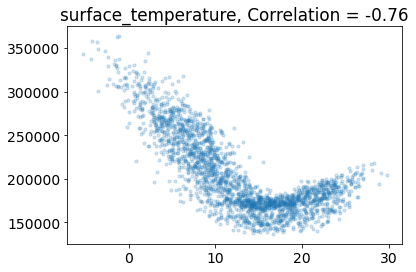

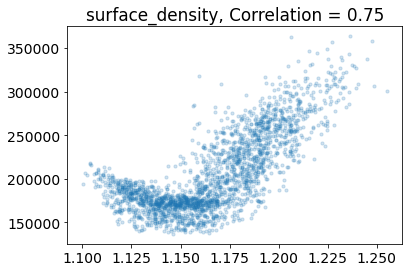

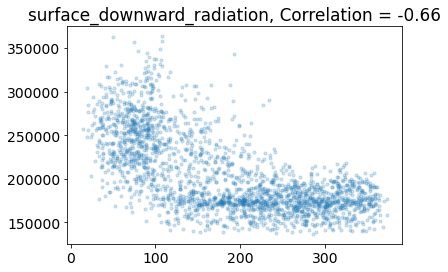

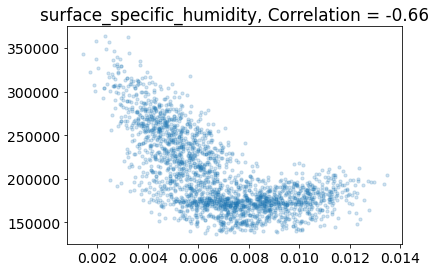

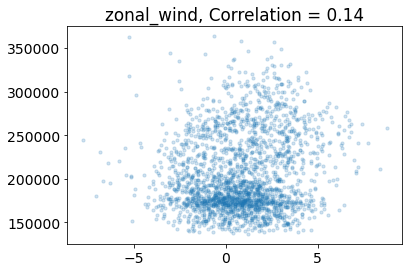

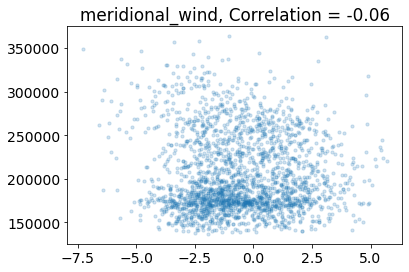

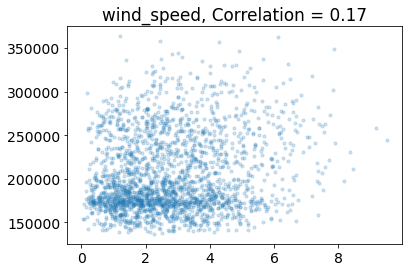

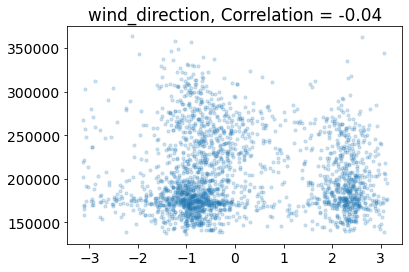

In [4]:
for variable_name, da in ds_clim_reg.items():
    plt.figure()
    plt.scatter(da.values, df_dem_reg.values, s=10, alpha=0.2)
    c = np.corrcoef(da.values, df_dem_reg.values)[0, 1]
    plt.title('{}, Correlation = {:.2f}'.format(variable_name, c))

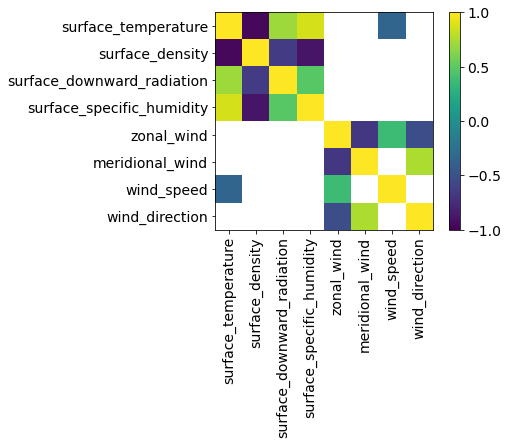

In [5]:
corr_clim = np.corrcoef(ds_clim_reg.to_array().values)
fig, ax = plt.subplots()
plt.imshow(np.where(np.abs(corr_clim) > 0.3, corr_clim, np.nan),
           vmin=-1., vmax=1.)
ticks = range(len(variable_names))
ticklabels = variable_names
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation=90.)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
plt.colorbar()

Answer:

### Preparing feature extraction

As in the previous tutorials, we define nonlinear features from the temperature based on heating- and cooling-temperatures.

In [6]:
# Define heating and cooling temperature thresholds
TEMP_HEAT = 16.
TEMP_COOL = 19.

# Define function returning a dictionary from variable name
# to variable train data with base, heating and cooling variables
def get_base_heat_cool(x):
    return {
        'heat': (TEMP_HEAT - x) * (x < TEMP_HEAT).astype(float),
        'cool': (x - TEMP_COOL) * (x > TEMP_COOL).astype(float)
    }

We also define a factorization by month.
In other words, for each variable, we define 12 new variables for which the values are that of the original variable for dates in the corresponding month, zero otherwise.

In [7]:
def factorize_monthly(variables, index):
    new_variables = {}
    for variable_name, variable_data in variables.items():
        for month in range(1, 13):
            new_variable_name = '{}_m{:02d}'.format(variable_name, month)
            new_variables[new_variable_name] = variable_data * (
                index.month == month).astype(float)
            
    return new_variables

> ***Question***
> - If 4 climate variables are selected, how may features will result from the monthly factorization?

Answer: 

### Regressions evaluation function

We also define a function to evaluate any of our regressions.

`FIRST_TEST_YEAR` controls the number of years at the end of the time series to keep as test data.

In [8]:
from sklearn import model_selection

# Default number of test days
FIRST_TEST_YEAR = 2018

def evaluate_regressor(
    reg, reg_kwargs, param_name, param_range, first_test_year=FIRST_TEST_YEAR,
    n_splits=None, cv_iterator=model_selection.GroupKFold,
    plot_validation=True):
    
    if n_splits is None:
        n_splits = len(np.unique(time[time.year < first_test_year].year))
    
    # Get test data keeping last years
    index_test = time.year >= first_test_year
    x_test = x[index_test]
    X_test = X[index_test]
    y_test = y[index_test]
    
    # Select train data from first years and first days in month 
    index_train = time.year < first_test_year
    X_train = X[index_train]
    y_train = y[index_train]
    
    if plot_validation:
        # Set cross-validation iterator
        cv = cv_iterator(n_splits=n_splits)
        groups = time[index_train].year

        # Get train and validation scores from cross-validation
        train_scores, validation_scores = model_selection.validation_curve(
            reg, X_train, y_train, param_name=param_name,
            param_range=param_range, cv=cv, groups=groups)

        # Get train curve
        train_scores_mean = train_scores.mean(1)
        train_scores_max = train_scores.max(1)
        train_scores_min = train_scores.min(1)

        # Get validation curve
        validation_scores_mean = validation_scores.mean(1)
        validation_scores_max = validation_scores.max(1)
        validation_scores_min = validation_scores.min(1)

        # Get best value of the regularization parameter
        i_best = np.argmax(validation_scores_mean)
        param_best = param_range[i_best]
        score_best = validation_scores_mean[i_best]

    
        # Plot validation curve
        lw = 2
        plt.figure()
        plt.semilogx(param_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=lw)
        plt.fill_between(param_range, train_scores_min, train_scores_max,
                         alpha=0.2, color="darkorange", lw=lw)
        plt.semilogx(param_range, validation_scores_mean,
                     label="Cross-validation score", color="navy", lw=lw)
        plt.fill_between(
            param_range, validation_scores_min, validation_scores_max,
            alpha=0.2, color="navy", lw=lw)
        plt.xlabel(param_name)
        plt.ylabel(r'Validation $r^2$')
        plt.title(REGION_NAME + r'. Best $r^2$: {:.2} for {} = {:.1e}'.format(
            score_best, param_name, param_best))
        plt.ylim(0.0, 1.1)
        plt.legend(loc="best")
        
        # Set best parameter
        reg.set_params(**{param_name: param_best})
    else:
        param_best = reg.get_params(param_name)
        
    # Compute prediction error conditioned on first 5 years of data
    reg.fit(X_train, y_train)
    test_score = reg.score(X_test, y_test)
    print('\nTest r2: {:.2f}'.format(test_score))

    # Predict for work days and off days
    y_pred = reg.predict(X_test)

    # Plot prediction on top of train data versus temperature
    plt.figure()
    plt.scatter(x_test, y_test, s=10, alpha=0.5)
    plt.scatter(x_test, y_pred, s=10)
    plt.xlabel(temp_label)
    plt.ylabel(dem_label)
    plt.title(REGION_NAME)

    # Scatter plot of prediction against target
    plt.figure()
    plt.scatter(y_test, y_pred, s=10, alpha=0.5)
    plt.xlabel('Target ' + dem_label)
    plt.ylabel('Predicted ' + dem_label)
    plt.title(REGION_NAME)
    
    return {param_name: param_best}

> ***Question***
> - If 2018 is given as the first test years, how many training years and test years will be available for this dataset?
> - Identify the lines where:
>   - The validation and train scores are computed;
>   - The test score is computed;
>   - The target is predicted from the test input features.

Answer: 

## Feature selection

The following code select features, by controlling:
- The climate variables to select in addition to the heating- and cooling-temperatures;
- Whether a monthly factorization is performed or not;
- The degree of polynomial interactions;
- The standardization of the features.

It also plots the time series features associated with each selected climate variable.

> ***Question***
> - Identify the lines where:
>   - The heating and cooling temperatures are obtained;
>   - The other climate variables are added;
>   - The monthly factorization is applied;
>   - The polynomial features are computed;
>   - The standardization is performed.
> - Are the feature time series in agreement with your expectations?

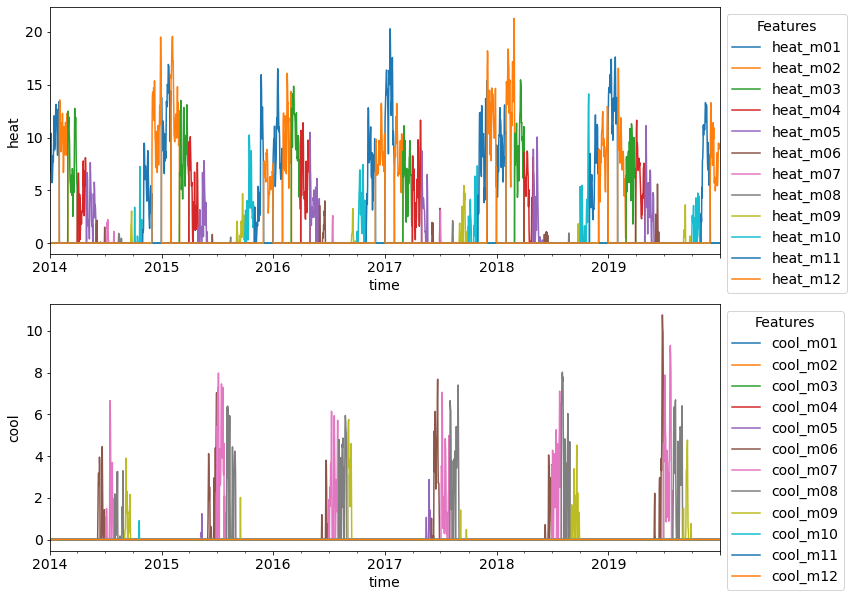

In [9]:
from sklearn import preprocessing

# Variables in addition to temperature features
ADDITIONAL_VARIABLE_NAMES = []
# ADDITIONAL_VARIABLE_NAMES = [
#     'surface_density', 'surface_downward_radiation',
#     'surface_specific_humidity', 'wind_speed', 'wind_direction'
# ]

# Degree of polynomial interactions
POLY_DEGREE = 1

# Get features
x = ds_clim_reg['surface_temperature'].values
y = df_dem_reg.values
features = get_base_heat_cool(x)
for var_name in ADDITIONAL_VARIABLE_NAMES:
    features[var_name] = ds_clim_reg[var_name].values
feature_names_nofact = list(features)

# Factorize monthly
features = factorize_monthly(features, time)

# Plot features before polynomial transform and standardization
feature_names = list(features)
df_features = pd.DataFrame(features, index=time)
n_feat_nofact = len(feature_names_nofact)
fig, axs = plt.subplots(n_feat_nofact, figsize=[12, 5 * n_feat_nofact])
for k, feature_name in enumerate(feature_names_nofact):
    try:
        ax = axs[k]
    except TypeError:
        ax = axs
    feat_variables = [feature_name in v for v in feature_names]
    df_features.iloc[:, feat_variables].plot(ax=ax, ylabel=feature_name)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', title='Features')

# Get input matrix
X = np.array(list(features.values())).T
if POLY_DEGREE > 1:
    poly = preprocessing.PolynomialFeatures(POLY_DEGREE)
    X =  poly.fit_transform(X)
    
# Standardize
X = preprocessing.StandardScaler().fit_transform(X)

Answer: 

## Individual models

First, make sure that only the heating and cooling temperatures are selected as features, that the monthly factorization is activated and that no polynomial transformation is performed.

### Lasso regression

The following code:
- Creates a Lasso regressor with positive coefficients;
- Evaluate the regressor over a range of regularization parameter values;
- Represent the importance of the coefficients.

The evaluation function:
- Plots the training and validation curves with the lines representing the mean score and the shading the minimum and maximum scores;
- Plots test predictions against the test inputs over the train data;
- Plots the test predictions against the test targets.

> ***Question***
> - Is there an overfit/underfit tradeoff?
> - Explain the difference between the training curve and the validation curve?
> - Explain the evolution the variability of the validation curve.
> - Is the test score in agreement with the best validation score?
> - How does the the importance of the coefficients vary with climate variable and the month?


Test r2: 0.85


<AxesSubplot:>

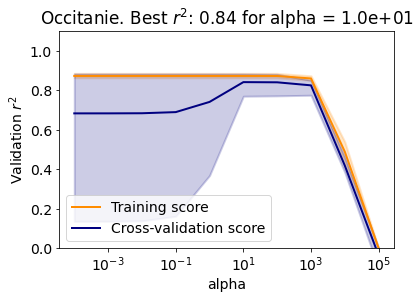

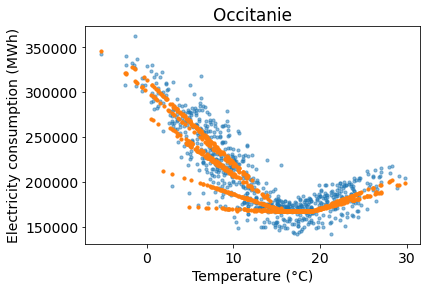

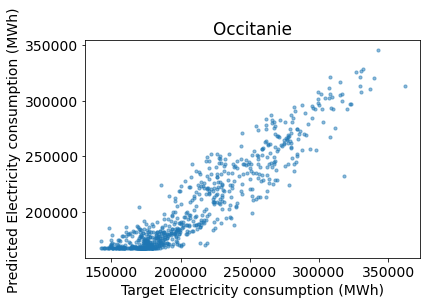

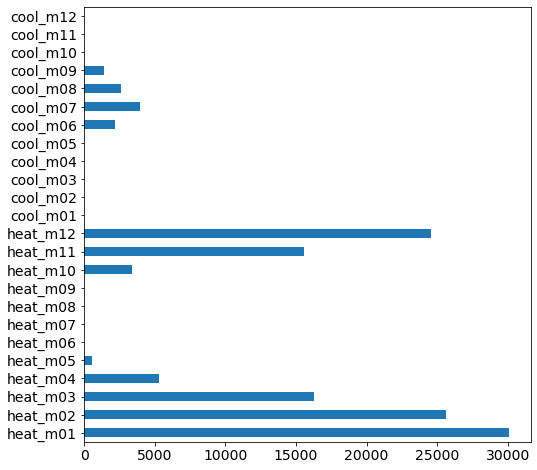

In [10]:
from sklearn import linear_model

# Define array of complexity coordinate, regressor and options
# for Lasso regression
param_name, param_range = 'alpha', np.logspace(-4, 5, 10)
reg_kwargs_lasso = dict(fit_intercept=True, warm_start=True,
                        positive=True, max_iter=1e4)
reg_lasso = linear_model.Lasso(
    **{param_name: param_range[0]}, **reg_kwargs_lasso)

# Evaluate regressor
param_best_lasso = evaluate_regressor(
    reg_lasso, reg_kwargs_lasso, param_name, param_range)
index = feature_names if POLY_DEGREE == 1 else None
df_coef = pd.Series(reg_lasso.coef_, index=index)
plt.figure()
df_coef.plot(kind='barh', figsize=(8, 8))

Answer: 

### Decision-tree regression

The following code:
- Creates a decision-tree regressor;
- Evaluate the regressor over a range of maximum tree depth;

> ***Question***
> - Is there an overfit/underfit tradeoff?
> - How does the tree perform compared to the Lasso?


Test r2: 0.78


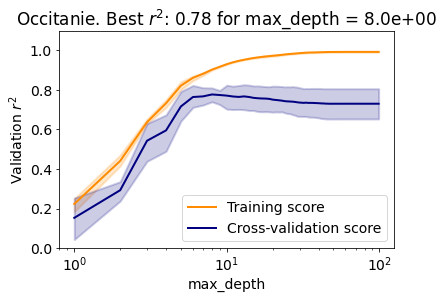

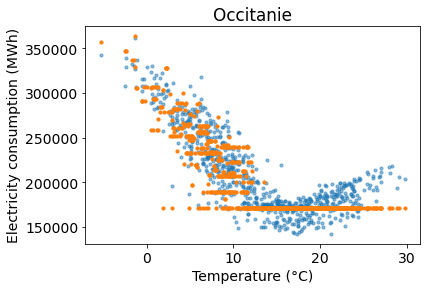

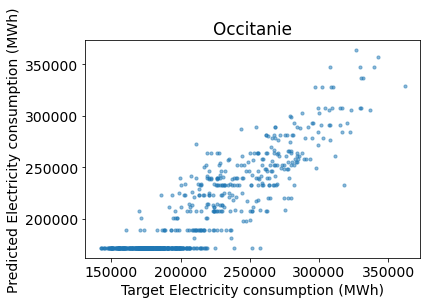

In [11]:
from sklearn import tree

# Define array of complexity coordinate, regressor and options
# for decision-tree regression
param_name, param_range = 'max_depth', np.arange(1, 100, 1)
reg_kwargs_dt = dict()
reg_dt = tree.DecisionTreeRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_dt)

# Evaluate regressor
param_best_dt = evaluate_regressor(
    reg_dt, reg_kwargs_dt, param_name, param_range)

Answer:

## Ensemble models

### Bagging regressor

The following code:
- Creates a bagging regressor with a decision tree as a base estimator;
- Evaluate the regressor over a range of number of estimators;

> ***Question***
> - Use the Scikit-learn documentation to give the parameters defining this bagging regressor.

> ***Question***
> - Is there an overfit/underfit tradeoff?
> - In this case, how to choose the number of estimators?
> - Same question without using validation curves.
> - How does the bagging perform compared to the individual regressors?


Test r2: 0.81


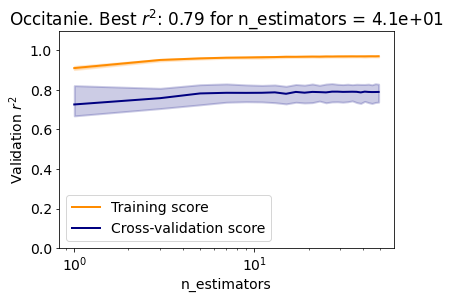

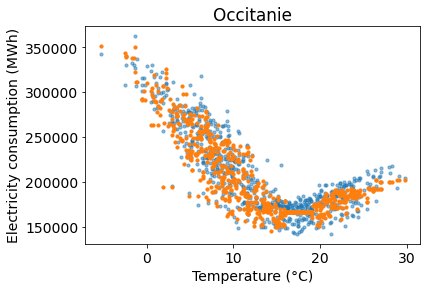

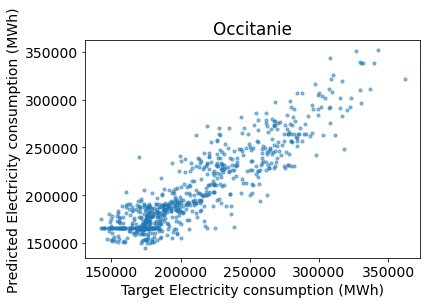

In [12]:
from sklearn import ensemble

# Define array of complexity coordinate, regressor and options
# for Bagging regression
param_name, param_range = 'n_estimators', np.arange(1, 50, 2)
base_estimator = None
reg_kwargs_br = dict(base_estimator=base_estimator)
reg_br = ensemble.BaggingRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_br)

# Evaluate regressor
param_best_br = evaluate_regressor(
    reg_br, reg_kwargs_br, param_name, param_range)

Answer: 

### Random-forest regressor

The following code:
- Creates a random-forest regressor;
- Evaluate the regressor over a range of number of estimators;

> ***Question***
> - Use the Scikit-learn documentation to give the parameters defining this random-forest regressor.

> ***Question***
> - How does the random forest perform compared to the bagging regressor?
> - Compare the varibility of the validation score of the random forest to that of the bagging regressor.


Test r2: 0.80


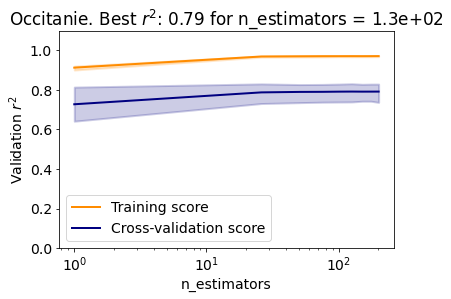

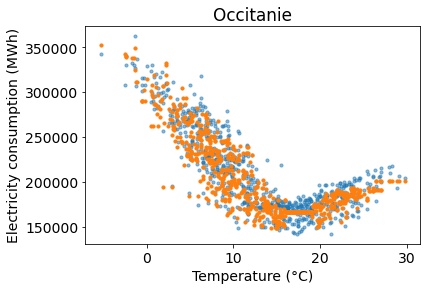

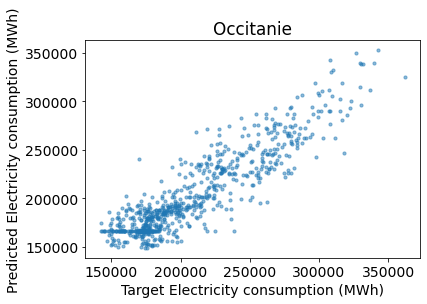

In [13]:
# Define array of complexity coordinate, regressor and options
# for random-forest regression
param_name, param_range = 'n_estimators', np.arange(1, 202, 25)
reg_kwargs_rf = dict()
reg_rf = ensemble.RandomForestRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_rf)

# Evaluate regressor
param_best_rf = evaluate_regressor(
    reg_rf, reg_kwargs_rf, param_name, param_range)

Answer: 

The following plot represents the mean and standard deviation of the importance given to the features by the trees in the random forest (see [Feature importance with a forest of trees in Scikit-learn User guide](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importances-with-a-forest-of-trees)).

> ***Question***
> - How does the the importance of the features vary with climate variable and the month?
> - Compare the importance of the random-forest features with that of the Lasso.

Text(0, 0.5, 'Mean decrease in impurity')

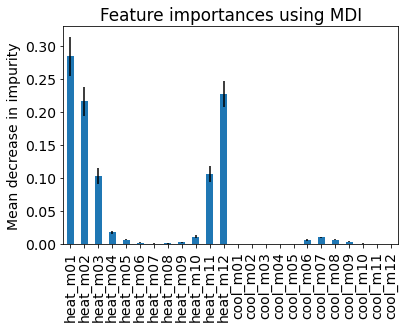

In [14]:
# Plot importance
importances = reg_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=index)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Answer: 

### Voting regressor

The following code creates a voting regressor with the Lasso, the decision tree and the random forest as base estimators and tests it.

> ***Question***
> - Use the Scikit-learn documentation to give the parameters defining this voting regressor.

> ***Question***
> - How does the voting regressor perform compared to the base estimators?


Test r2: 0.84


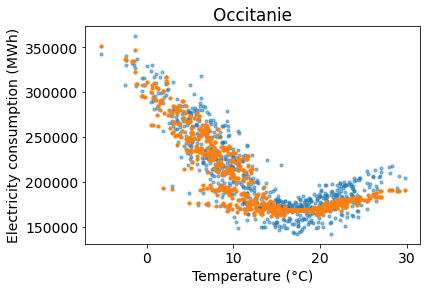

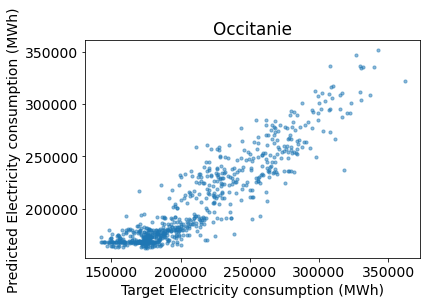

In [15]:
# Define array of complexity coordinate, regressor and options
# for voting regression
param_name, param_range = 'estimators', [
    [('Lasso', reg_lasso), ('DecisionTree', reg_dt), ('RandomForest', reg_rf)]
]
reg_kwargs_vr = dict()
reg_vr = ensemble.VotingRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_vr)

# Evaluate regressor
param_best_vr = evaluate_regressor(
    reg_vr, reg_kwargs_vr, param_name, param_range,
    plot_validation=False)

Answer: 

### Stacking regressor

- The following code creates a stacking regressor with the Lasso, the decision tree and the random forest as base estimators and tests it.
- The final regressor is a OLS with positive coefficients.
- The weights given to the base estimators by the stacking are also given.

> ***Question***
> - Use the Scikit-learn documentation to give the parameters defining this stacking regressor.

> ***Question***
> - How does the stacking regressor perform compared to the voting regressor? Why?


Test r2: 0.86
Weights:
Lasso           0.823766
DecisionTree    0.000000
RandomForest    0.170232
dtype: float64


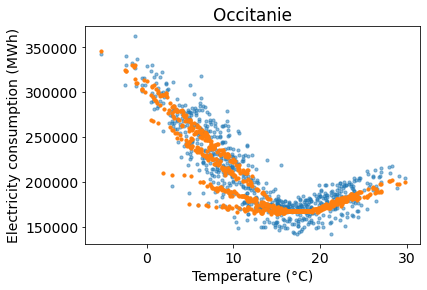

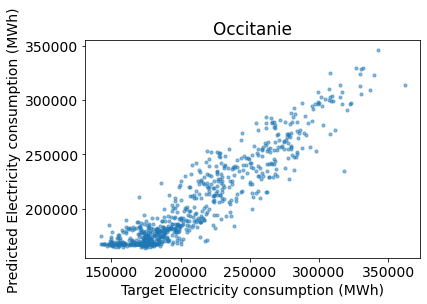

In [16]:
# Define array of complexity coordinate, regressor and options
# for voting regression
param_name, param_range = 'estimators', [
    [('Lasso', reg_lasso), ('DecisionTree', reg_dt), ('RandomForest', reg_rf)]
]
reg_kwargs_sr = dict(final_estimator=linear_model.LinearRegression(
    positive=True))
reg_sr = ensemble.StackingRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_sr)

# Evaluate regressor
param_best_sr = evaluate_regressor(
    reg_sr, reg_kwargs_sr, param_name, param_range, plot_validation=False)
weights = reg_sr.final_estimator_.coef_
index = [r[0] for r in param_range[0]]
df_weights = pd.Series(weights, index=index)
print('Weights:')
print(df_weights)

Answer:

### AdaBoost regressor

The following code:
- Creates an AdaBoost regressor;
- Evaluate the regressor over a range of number of estimators;

> ***Question***
> - Use the Scikit-learn documentation to give the parameters defining this AdaBoost regressor.

> ***Question***
> - How does the AdaBoost compared to the other regressors?


Test r2: 0.85


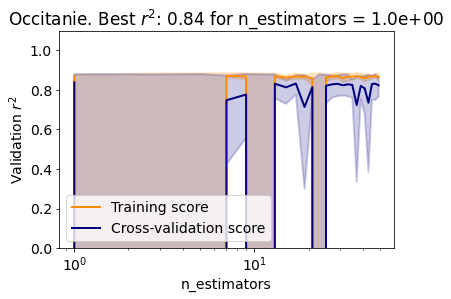

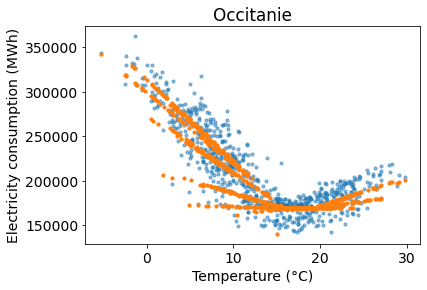

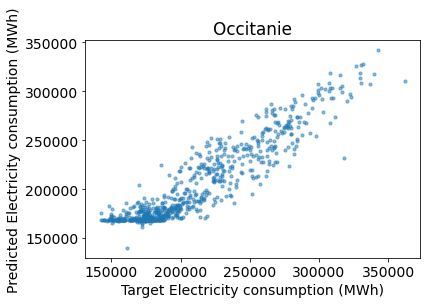

In [17]:
# Define array of complexity coordinate, regressor and options
# for AdaBoost regression
param_name, param_range = 'n_estimators', np.arange(1, 50, 2)
base_estimator = linear_model.LinearRegression(fit_intercept=True)
reg_kwargs_abr = dict(base_estimator=base_estimator)
reg_abr = ensemble.AdaBoostRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_abr)

# Evaluate regressor
param_best_abr = evaluate_regressor(
    reg_abr, reg_kwargs_abr, param_name, param_range)

Answer: 

> ***Question (optional)***
> - Reevaluate your results when changing:
>   - The combination of selected climate variables;
>   - The degree of the polynomial features;
>   - The activation of the monthly factorization.

Answer: 

> ***Question (Optional)***
> - Reevaluate your results for different regions.

Answer: 

> ***Question (Optional)***
> - Reevaluate your results for a different scoring metric.

Answer: 

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>